# Credit Monitoring System

## Environment Setup


This section imports the foundational Python libraries required for a credit risk modeling pipeline:

+ pandas and numpy for data manipulation and numerical operations.

+ seaborn and matplotlib.pyplot for data visualization.

sklearn modules for modeling:

+ train_test_split to create out-of-sample test data for model evaluation.

+ LogisticRegression as our baseline credit risk classifier.

+ SimpleImputer to handle missing values, a common issue in financial data.

+ MinMaxScaler to normalize features, ensuring uniform scale prior to model training.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

## Data Setup

In a production credit risk environment, it's best practice to compare model performance on developmental data (historical observations the model is trained on) against recent data (more current records to simulate future or out-of-time performance). This helps assess model stability and potential for concept drift.

Why this approach:

Because we lack clearly time-stamped data, we simulate this structure using the provided datasets:

+ train → used as a proxy for developmental data (older records, known outcomes).

+ test → used as a proxy for recent data (newer accounts, simulating unseen customers).

This enables:

+ Performance comparison across "time"

+ Stability Index analysis

+ Realistic model validation under production-like conditions

In [2]:
dev_data = pd.read_csv(r'/content/cs-training.csv')

In [3]:
rec_data = pd.read_csv(r'/content/cs-test.csv')

## Building a Simulated Internal Credit Scorecard


In the absence of a production-grade internal scoring system, this section simulates the creation of a simplified internal credit score using logistic regression. While real-world credit scorecards involve complex business rules, segmentation strategies, regulatory constraints, and champion-challenger testing, the focus here is to construct a baseline model for use in credit risk monitoring.

The output of this section will be a new, internal scoring variable (Internal_Credit_Scoring) along with associated default probabilities, which are used in later monitoring sections to evaluate population drift, score stability, and portfolio performance degradation.

### Step 1: Simulated Internal Scorecard Using Logistic Regression

Key Assumptions and Regulatory Considerations:
+ We’ve excluded age due to its potential for regulatory scrutiny (think ECOA).

+ The goal here is not to optimize the model, but to generate a reasonable score for monitoring purposes downstream.

By providing a printout of the actual logit equation allows stakeholders to review, audit, and challenge the scorecard. In real-world governance, this is often required before a model can be deployed.

In [4]:
df_train = dev_data.copy()
df_train = df_train.drop(columns=['Unnamed: 0', 'age'])

X = df_train.drop(columns='SeriousDlqin2yrs')
y = df_train['SeriousDlqin2yrs']

imputer = SimpleImputer(strategy='median')
scaler = MinMaxScaler()
X_imputed = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imputed)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

logit_train = model.intercept_[0] + np.dot(X_scaled, model.coef_[0])
p_train = 1 / (1 + np.exp(-logit_train))
score_train = 850 - (p_train * 550)

df_train["Default_Probability"] = p_train
df_train["Internal_Credit_Score"] = score_train

In [5]:
coefficients = model.coef_[0]
intercept = model.intercept_[0]
feature_names = X.columns

logit_terms = [f"{coef:.4f} * {name}" for coef, name in zip(coefficients, feature_names)]
logit_expression = f"{intercept:.4f} + " + " + ".join(logit_terms)

print("Compute logit (z)")
print(f"logit = {logit_expression}\n")

print("Compute probability of default")
print("P_default = 1 / (1 + exp(-logit))\n")

print("Compute Internal_Credit_Score Score")
print("Customer_Score = 850 - (P_default * 550)\n")

Compute logit (z)
logit = -2.6241 + -0.2150 * RevolvingUtilizationOfUnsecuredLines + 13.2354 * NumberOfTime30-59DaysPastDueNotWorse + -0.5974 * DebtRatio + -1.8755 * MonthlyIncome + -1.2933 * NumberOfOpenCreditLinesAndLoans + 3.8985 * NumberOfTimes90DaysLate + 0.3409 * NumberRealEstateLoansOrLines + -13.4839 * NumberOfTime60-89DaysPastDueNotWorse + 3.0234 * NumberOfDependents

Compute probability of default
P_default = 1 / (1 + exp(-logit))

Compute Internal_Credit_Score Score
Customer_Score = 850 - (P_default * 550)



### Step 2: Use the formula to score the test set

In [6]:
df_test = rec_data.copy()
df_test = df_test.drop(columns=['Unnamed: 0', 'age'], errors='ignore')
X_test_features = df_test.drop(columns=['SeriousDlqin2yrs'], errors='ignore')

X_test_imputed = imputer.transform(X_test_features)
X_test_scaled = scaler.transform(X_test_imputed)

logit_test = intercept + np.dot(X_test_scaled, coefficients)
p_test = 1 / (1 + np.exp(-logit_test))
score_test = 850 - (p_test * 550)

df_test["Default_Probability"] = p_test
df_test["Internal_Credit_Score"] = score_test


In [7]:
print("\nSample of df_train:")
print(df_train[["Default_Probability", "Internal_Credit_Score"]].head())

print("\nSample of df_test:")
print(df_test[["Default_Probability", "Internal_Credit_Score"]].head())


Sample of df_train:
   Default_Probability  Internal_Credit_Score
0             0.090352             800.306533
1             0.071508             810.670467
2             0.076156             808.114220
3             0.060788             816.566695
4             0.064256             814.659171

Sample of df_test:
   Default_Probability  Internal_Credit_Score
0             0.061986             815.907555
1             0.066814             813.252324
2             0.070032             811.482584
3             0.066950             813.177368
4             0.071456             810.699253


In [8]:
dev_data[["Default_Probability", "Internal_Credit_Score"]] = df_train[["Default_Probability", "Internal_Credit_Score"]]
rec_data[["Default_Probability", "Internal_Credit_Score"]] = df_test[["Default_Probability", "Internal_Credit_Score"]]

## PSI (Population Shift Index)

In credit risk monitoring, the Population Stability Index (PSI) is a widely used statistical measure that quantifies how much a scoring distribution has shifted over time. It helps detect changes in the applicant population, which may indicate:

+ Model performance degradation

+ Customer behavior changes

+ Operational or policy changes

+ Data pipeline or input issues

In this section, we compute the PSI between our simulated internal credit scores from the developmental dataset (used to build the score) and the recent dataset (representing newer applicants).

The goal of the PSI, is to determine whether the score distribution has remained stable over time or if there's evidence of population drift that could affect model reliability.

The PSI report will contain the following columns:

+ **Score Band** : The internal credit score bin (e.g., deciles) used to group applicants by risk level.  
+ **Development Apps #** : The number of applicants in each score band during the development period.  
+ **Current Apps #** : The number of applicants in each band in the recent dataset.  
+ **Development %** : Share of the development population in this score band.  
+ **Current %** : Share of the recent population in this band.  
+ **Change (decimal)** : Absolute percentage point shift in distribution from development to recent.  
+ **Ratio (Current % / Development %)** : Proportional change — values > 1 indicate growth; < 1 indicate shrinkage.  
+ **WOE ln(Ratio)** : Weight of Evidence — the natural log of the ratio, used to assess directional impact.  
+ **Contribution to Index** : The PSI contribution from this band. The sum of all rows equals the total PSI.


### Create decile bins using development data

In [9]:
assert 'Internal_Credit_Score' in dev_data.columns
assert 'Internal_Credit_Score' in rec_data.columns

dev_data['Score_Band'] = pd.qcut(dev_data['Internal_Credit_Score'], q=10, duplicates='drop')

bin_edges = dev_data['Score_Band'].cat.categories
rec_data['Score_Band'] = pd.cut(rec_data['Internal_Credit_Score'], bins=bin_edges, include_lowest=True)

dev_data['Dataset'] = 'Development'
rec_data['Dataset'] = 'Recent'

df = pd.concat([dev_data, rec_data], ignore_index=True)

### PSI Calculation Table

In [10]:
dev_data = df[df['Dataset'] == 'Development']
recent_data = df[df['Dataset'] == 'Recent']

dev_apps = dev_data['Score_Band'].value_counts().sort_index()
recent_apps = recent_data['Score_Band'].value_counts().sort_index()

dev_percent = dev_apps / dev_apps.sum() * 100
recent_percent = recent_apps / recent_apps.sum() * 100

change_percent = recent_percent - dev_percent
ratio = recent_percent / dev_percent.replace(0, np.nan)
woe = np.log(ratio.replace([np.inf, -np.inf], 0)).replace([np.inf, -np.inf], 0)
psi_contribution = (recent_percent - dev_percent) * woe

psi_report = pd.DataFrame({
    'Score Band': dev_apps.index.astype(str),
    'Development Apps #': dev_apps,
    'Current Apps #': recent_apps,
    'Development %': dev_percent.round(2),
    'Current %': recent_percent.round(2),
    'Change (decimal)': change_percent.round(2),
    'Ratio (Current % / Development %)': ratio.round(2),
    'WOE ln(Ratio)': woe.round(2),
    'Contribution to Index': psi_contribution.round(2)
})

total_row = pd.DataFrame({
    'Score Band': ['Total'],
    'Development Apps #': [dev_apps.sum()],
    'Current Apps #': [recent_apps.sum()],
    'Development %': [dev_percent.sum()],
    'Current %': [recent_percent.sum()],
    'Change (decimal)': [change_percent.sum()],
    'Ratio (Current % / Development %)': [None],
    'WOE ln(Ratio)': [None],
    'Contribution to Index': [psi_contribution.sum()]
})

psi_report = pd.concat([psi_report, total_row], ignore_index=True)
psi_report

<ipython-input-10-be1f7633c68b>:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  psi_report = pd.concat([psi_report, total_row], ignore_index=True)


,Score Band,Development Apps #,Current Apps #,Development %,Current %,Change (decimal),Ratio (Current % / Development %),WOE ln(Ratio),Contribution to Index
0,"(379.58000000000004, 803.303]",15000,10502,10.0,10.35,3.500000e-01,1.03,0.03,0.010000
1,"(803.303, 808.768]",15000,10088,10.0,9.94,-6.000000e-02,0.99,-0.01,0.000000
2,"(808.768, 812.149]",15000,10159,10.0,10.01,1.000000e-02,1.00,0.00,0.000000
3,"(812.149, 814.376]",15000,10140,10.0,9.99,-1.000000e-02,1.00,-0.00,0.000000
4,"(814.376, 815.723]",15000,9969,10.0,9.82,-1.800000e-01,0.98,-0.02,0.000000
5,"(815.723, 816.668]",15000,10011,10.0,9.86,-1.400000e-01,0.99,-0.01,0.000000
6,"(816.668, 817.934]",15000,10123,10.0,9.97,-3.000000e-02,1.00,-0.00,0.000000
7,"(817.934, 819.274]",15000,10228,10.0,10.08,8.000000e-02,1.01,0.01,0.000000
8,"(819.274, 821.246]",15000,10365,10.0,10.21,2.100000e-01,1.02,0.02,0.000000
9,"(821.246, 843.777]",15000,9912,10.0,9.77,-2.300000e-01,0.98,-0.02,0.010000


### Interpretation

**Total PSI Value: 0.027975**

Since the **Total PSI = 0.028**, which is **well below 0.10**, this suggests:

- No material shift in score distribution between the development and recent populations.  
- The model appears *stable*, with no immediate signs of concept drift or population instability.  

This is based according to the standard PSI thresholds (from the monitoring guide):


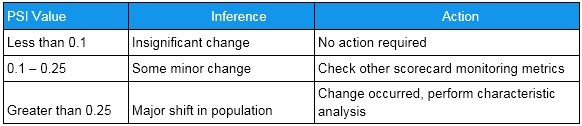

# CSI

### Creating the Function

In [11]:
def compute_csi(df, feature, bin_config, min_score=10, max_score=50):
    df = df.copy()
    bin_col = f"{feature}_Bins"

    df[bin_col] = pd.qcut(df[feature], q=10, duplicates='drop')

    dev_data = df[df['Dataset'] == 'Development']
    rec_data = df[df['Dataset'] == 'Recent']

    dev_counts = dev_data[bin_col].value_counts().sort_index()
    rec_counts = rec_data[bin_col].value_counts().sort_index()

    all_bins = dev_counts.index.union(rec_counts.index)
    dev_counts = dev_counts.reindex(all_bins, fill_value=0)
    rec_counts = rec_counts.reindex(all_bins, fill_value=0)

    dev_percent = (dev_counts / dev_counts.sum()) * 100
    rec_percent = (rec_counts / rec_counts.sum()) * 100
    change_percent = rec_percent - dev_percent

    ratio = rec_percent / dev_percent.replace(0, np.nan)
    ratio.replace([np.inf, -np.inf], 0, inplace=True)
    woe = np.log(ratio.replace(0, np.nan)).replace([np.inf, -np.inf], 0).fillna(0)

    psi_contrib = (rec_percent - dev_percent) * woe

    if woe.max() == woe.min():
        score_for_attribute = pd.Series(min_score, index=woe.index)
    else:
        score_for_attribute = min_score + (woe - woe.min()) * (max_score - min_score) / (woe.max() - woe.min())

    score_diff = change_percent * score_for_attribute

    csi_report = pd.DataFrame({
        f'{feature} Bins': all_bins.astype(str),
        'Development Apps #': dev_counts,
        'Current Apps #': rec_counts,
        'Development %': dev_percent.round(2),
        'Current %': rec_percent.round(2),
        'Change (decimal)': change_percent.round(2),
        'Ratio (Current % / Development %)': ratio.round(2),
        'WOE ln(Ratio)': woe.round(2),
        'Contribution to Index': psi_contrib.round(2),
        'Score for Attribute': score_for_attribute.round(2),
        'Score Difference': score_diff.round(2)
    })

    total_row = pd.DataFrame({
        f'{feature} Bins': ['Total'],
        'Development Apps #': [dev_counts.sum()],
        'Current Apps #': [rec_counts.sum()],
        'Development %': [dev_percent.sum()],
        'Current %': [rec_percent.sum()],
        'Change (decimal)': [change_percent.sum()],
        'Ratio (Current % / Development %)': [None],
        'WOE ln(Ratio)': [None],
        'Contribution to Index': [psi_contrib.sum()],
        'Score for Attribute': [None],
        'Score Difference': [score_diff.sum()]
    })

    return pd.concat([csi_report, total_row], ignore_index=True)


### Running the Function

<ipython-input-12-36ddab5531c5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_data['Dataset'] = 'Development'



 Full CSI Table for Feature: Unnamed: 0


<ipython-input-11-7d35ae5cd8aa>:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([csi_report, total_row], ignore_index=True)


,Unnamed: 0 Bins,Development Apps #,Current Apps #,Development %,Current %,Change (decimal),Ratio (Current % / Development %),WOE ln(Ratio),Contribution to Index,Score for Attribute,Score Difference
0,"(0.999, 12576.0]",12576,12576,8.38,12.39,4.010000e+00,1.48,0.39,1.560000,50.00,200.290000
1,"(12576.0, 25151.0]",12575,12575,8.38,12.39,4.010000e+00,1.48,0.39,1.560000,50.00,200.270000
2,"(25151.0, 37726.0]",12575,12575,8.38,12.39,4.010000e+00,1.48,0.39,1.560000,50.00,200.270000
3,"(37726.0, 50301.0]",12575,12575,8.38,12.39,4.010000e+00,1.48,0.39,1.560000,50.00,200.270000
4,"(50301.0, 62876.0]",12575,12575,8.38,12.39,4.010000e+00,1.48,0.39,1.560000,50.00,200.270000
5,"(62876.0, 75451.2]",12575,12575,8.38,12.39,4.010000e+00,1.48,0.39,1.560000,50.00,200.270000
6,"(75451.2, 88026.4]",12575,12575,8.38,12.39,4.010000e+00,1.48,0.39,1.560000,50.00,200.270000
7,"(88026.4, 100601.6]",12575,12575,8.38,12.39,4.010000e+00,1.48,0.39,1.560000,50.00,200.270000
8,"(100601.6, 124849.8]",24248,902,16.17,0.89,-1.528000e+01,0.05,-2.90,44.320000,10.00,-152.770000
9,"(124849.8, 150000.0]",25151,0,16.77,0.00,-1.677000e+01,0.00,0.00,-0.000000,45.25,-758.790000


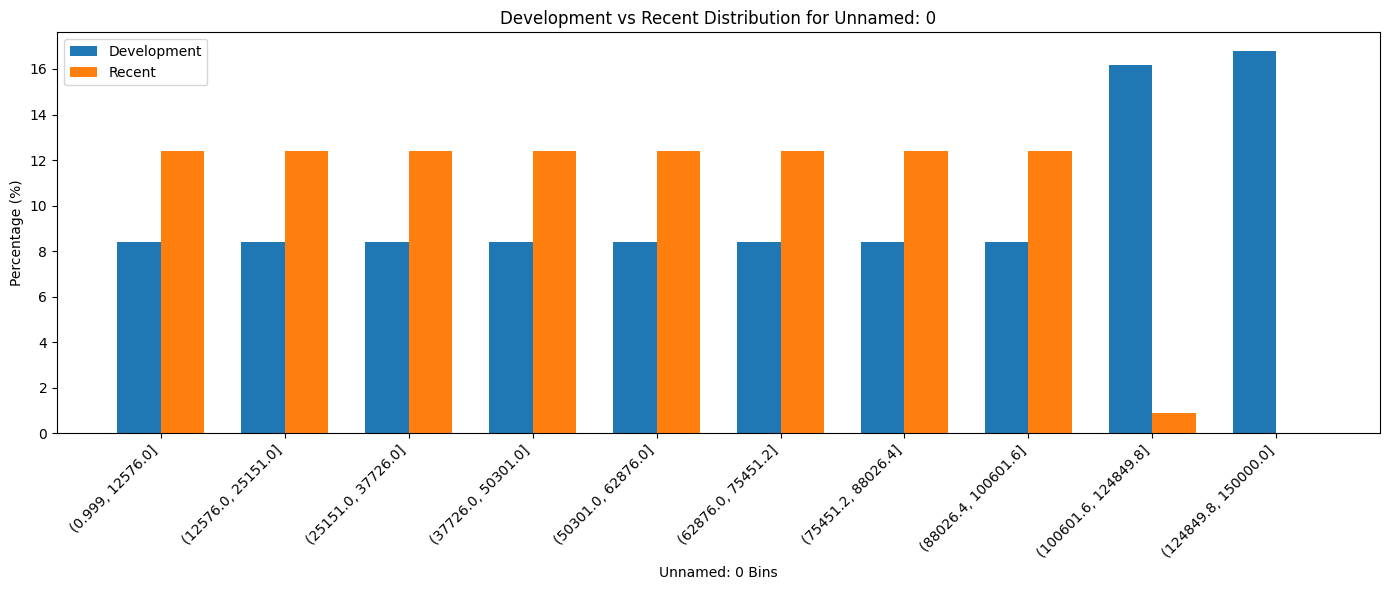


 Full CSI Table for Feature: RevolvingUtilizationOfUnsecuredLines


<ipython-input-11-7d35ae5cd8aa>:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([csi_report, total_row], ignore_index=True)


,RevolvingUtilizationOfUnsecuredLines Bins,Development Apps #,Current Apps #,Development %,Current %,Change (decimal),Ratio (Current % / Development %),WOE ln(Ratio),Contribution to Index,Score for Attribute,Score Difference
0,"(-0.001, 0.00299]",15016,10135,10.01,9.98,-0.03,1.00,-0.00,0.000000,28.71,-0.740000
1,"(0.00299, 0.0192]",14999,10151,10.00,10.00,0.00,1.00,0.00,0.000000,31.85,0.040000
2,"(0.0192, 0.0435]",14988,10162,9.99,10.01,0.02,1.00,0.00,0.000000,33.96,0.660000
3,"(0.0435, 0.083]",14944,10206,9.96,10.05,0.09,1.01,0.01,0.000000,42.36,3.910000
4,"(0.083, 0.154]",14938,10213,9.96,10.06,0.10,1.01,0.01,0.000000,43.62,4.500000
5,"(0.154, 0.271]",15094,10056,10.06,9.91,-0.16,0.98,-0.02,0.000000,13.65,-2.120000
6,"(0.271, 0.446]",15113,10037,10.08,9.89,-0.19,0.98,-0.02,0.000000,10.00,-1.870000
7,"(0.446, 0.702]",15065,10085,10.04,9.94,-0.11,0.99,-0.01,0.000000,19.21,-2.070000
8,"(0.702, 0.982]",14904,10246,9.94,10.09,0.16,1.02,0.02,0.000000,50.00,7.910000
9,"(0.982, 50708.0]",14939,10212,9.96,10.06,0.10,1.01,0.01,0.000000,43.43,4.410000


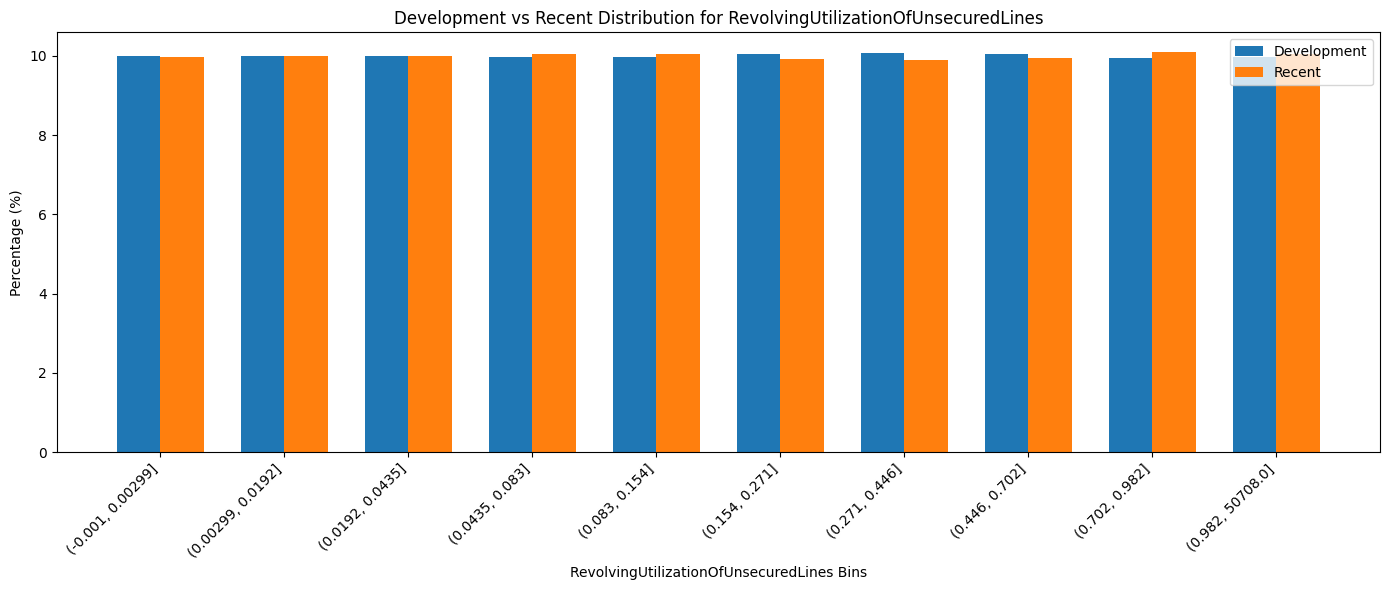


 Full CSI Table for Feature: age


<ipython-input-11-7d35ae5cd8aa>:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([csi_report, total_row], ignore_index=True)


,age Bins,Development Apps #,Current Apps #,Development %,Current %,Change (decimal),Ratio (Current % / Development %),WOE ln(Ratio),Contribution to Index,Score for Attribute,Score Difference
0,"(-0.001, 33.0]",17085,11291,11.39,11.12,-2.700000e-01,0.98,-0.02,0.010000,10.00,-2.660000
1,"(33.0, 39.0]",14919,10077,9.95,9.93,-2.000000e-02,1.00,-0.00,0.000000,30.47,-0.560000
2,"(39.0, 44.0]",15799,10729,10.53,10.57,4.000000e-02,1.00,0.00,0.000000,35.53,1.330000
3,"(44.0, 48.0]",14741,10019,9.83,9.87,4.000000e-02,1.00,0.00,0.000000,36.32,1.570000
4,"(48.0, 52.0]",14826,10036,9.88,9.89,0.000000e+00,1.00,0.00,0.000000,32.52,0.110000
5,"(52.0, 56.0]",14214,9626,9.48,9.48,1.000000e-02,1.00,0.00,0.000000,32.93,0.250000
6,"(56.0, 61.0]",16878,11377,11.25,11.21,-4.000000e-02,1.00,-0.00,0.000000,28.56,-1.240000
7,"(61.0, 65.0]",12939,8706,8.63,8.58,-5.000000e-02,0.99,-0.01,0.000000,26.86,-1.310000
8,"(65.0, 72.0]",14258,9833,9.51,9.69,1.800000e-01,1.02,0.02,0.000000,50.00,9.100000
9,"(72.0, 109.0]",14341,9809,9.56,9.66,1.000000e-01,1.01,0.01,0.000000,42.26,4.360000


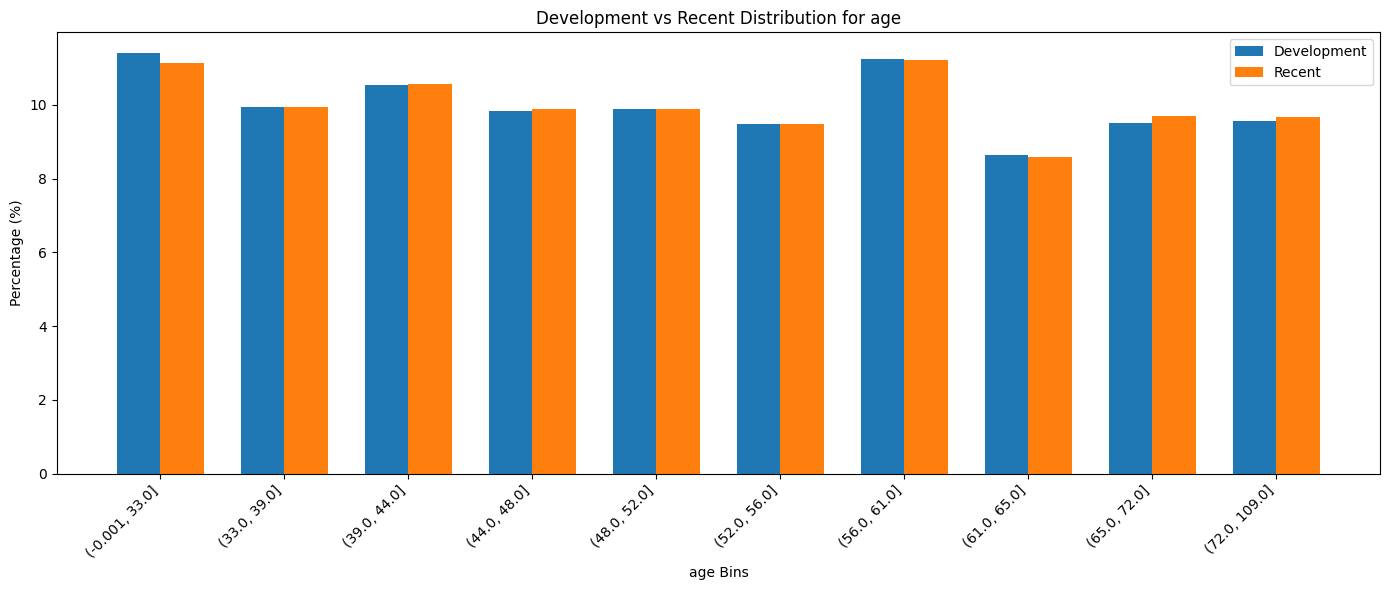


 Full CSI Table for Feature: NumberOfTime30-59DaysPastDueNotWorse


<ipython-input-11-7d35ae5cd8aa>:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([csi_report, total_row], ignore_index=True)


,NumberOfTime30-59DaysPastDueNotWorse Bins,Development Apps #,Current Apps #,Development %,Current %,Change (decimal),Ratio (Current % / Development %),WOE ln(Ratio),Contribution to Index,Score for Attribute,Score Difference
0,"(-0.001, 1.0]",142051,96027,94.7,94.61,-0.1,1.00,-0.00,0.000000,10.0,-0.960000
1,"(1.0, 98.0]",7949,5476,5.3,5.39,0.1,1.02,0.02,0.000000,50.0,4.780000
2,Total,150000,101503,100.0,100.00,0.0,NaN,NaN,0.001805,NaN,3.823244


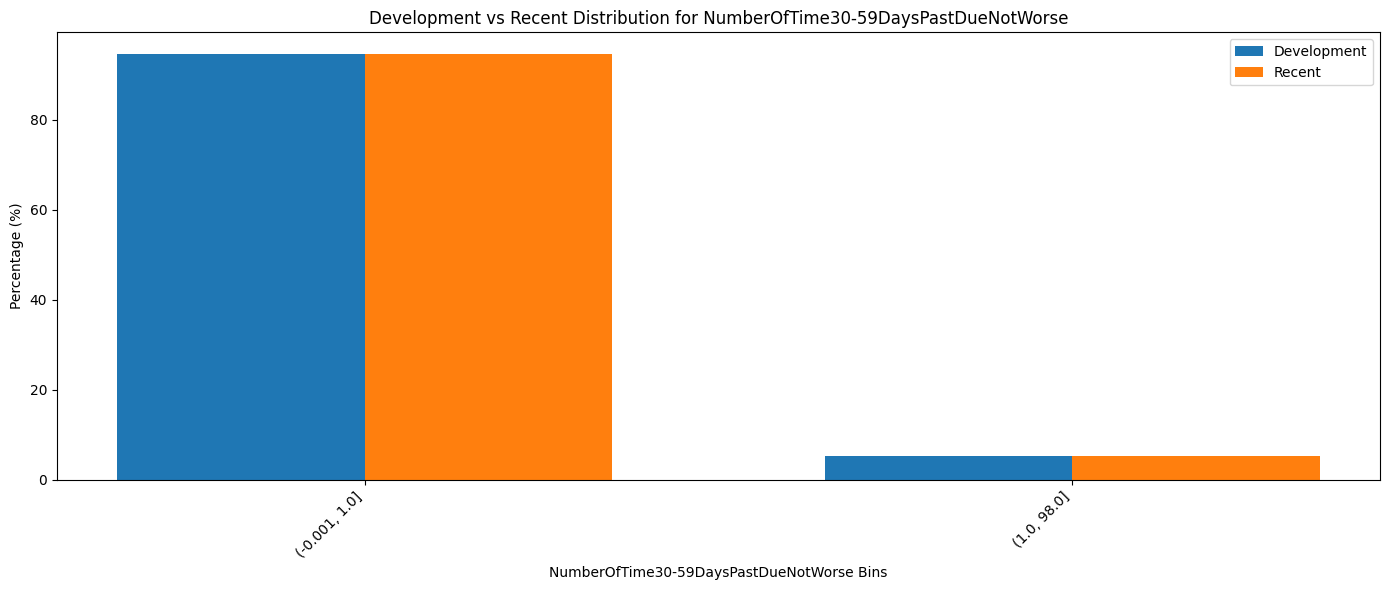


 Full CSI Table for Feature: DebtRatio


<ipython-input-11-7d35ae5cd8aa>:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([csi_report, total_row], ignore_index=True)


,DebtRatio Bins,Development Apps #,Current Apps #,Development %,Current %,Change (decimal),Ratio (Current % / Development %),WOE ln(Ratio),Contribution to Index,Score for Attribute,Score Difference
0,"(-0.001, 0.0305]",14957,10194,9.97,10.04,7.000000e-02,1.01,0.01,0.000000,45.63,3.270000
1,"(0.0305, 0.133]",14937,10213,9.96,10.06,1.000000e-01,1.01,0.01,0.000000,50.00,5.190000
2,"(0.133, 0.213]",14953,10197,9.97,10.05,8.000000e-02,1.01,0.01,0.000000,46.39,3.590000
3,"(0.213, 0.287]",15043,10109,10.03,9.96,-7.000000e-02,0.99,-0.01,0.000000,26.34,-1.830000
4,"(0.287, 0.366]",14961,10188,9.97,10.04,6.000000e-02,1.01,0.01,0.000000,44.46,2.810000
5,"(0.366, 0.466]",15013,10137,10.01,9.99,-2.000000e-02,1.00,-0.00,0.000000,32.85,-0.720000
6,"(0.466, 0.645]",14941,10209,9.96,10.06,1.000000e-01,1.01,0.01,0.000000,49.10,4.770000
7,"(0.645, 3.908]",15114,10036,10.08,9.89,-1.900000e-01,0.98,-0.02,0.000000,10.00,-1.890000
8,"(3.908, 1256.0]",15012,10150,10.01,10.00,-1.000000e-02,1.00,-0.00,0.000000,34.70,-0.290000
9,"(1256.0, 329664.0]",15069,10070,10.05,9.92,-1.300000e-01,0.99,-0.01,0.000000,18.70,-2.340000


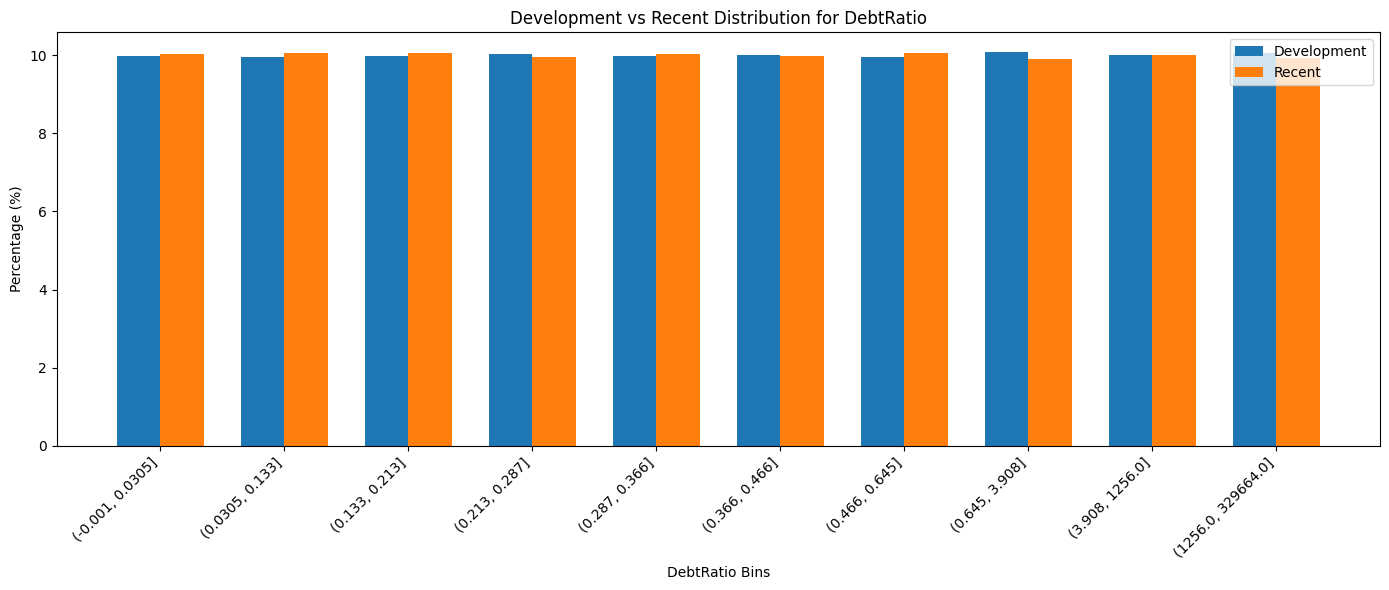


 Full CSI Table for Feature: MonthlyIncome


<ipython-input-11-7d35ae5cd8aa>:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([csi_report, total_row], ignore_index=True)


,MonthlyIncome Bins,Development Apps #,Current Apps #,Development %,Current %,Change (decimal),Ratio (Current % / Development %),WOE ln(Ratio),Contribution to Index,Score for Attribute,Score Difference
0,"(-0.001, 2044.0]",12192,7978,10.14,9.80,-3.400000e-01,0.97,-0.03,0.010000,10.00,-3.360000
1,"(2044.0, 3000.0]",12892,8795,10.72,10.80,9.000000e-02,1.01,0.01,0.000000,35.36,3.020000
2,"(3000.0, 3800.0]",11322,7912,9.41,9.72,3.100000e-01,1.03,0.03,0.010000,50.00,15.300000
3,"(3800.0, 4550.0]",11784,7882,9.80,9.68,-1.100000e-01,0.99,-0.01,0.000000,23.35,-2.680000
4,"(4550.0, 5400.0]",12125,8149,10.08,10.01,-7.000000e-02,0.99,-0.01,0.000000,26.26,-1.850000
5,"(5400.0, 6300.0]",11850,8192,9.85,10.06,2.100000e-01,1.02,0.02,0.000000,43.43,9.160000
6,"(6300.0, 7500.0]",12351,8345,10.27,10.25,-2.000000e-02,1.00,-0.00,0.000000,29.49,-0.520000
7,"(7500.0, 9060.0]",11594,7976,9.64,9.80,1.600000e-01,1.02,0.02,0.000000,40.46,6.410000
8,"(9060.0, 11600.0]",12017,8196,9.99,10.07,8.000000e-02,1.01,0.01,0.000000,35.21,2.710000
9,"(11600.0, 7727000.0]",12142,7975,10.10,9.80,-3.000000e-01,0.97,-0.03,0.010000,12.27,-3.660000


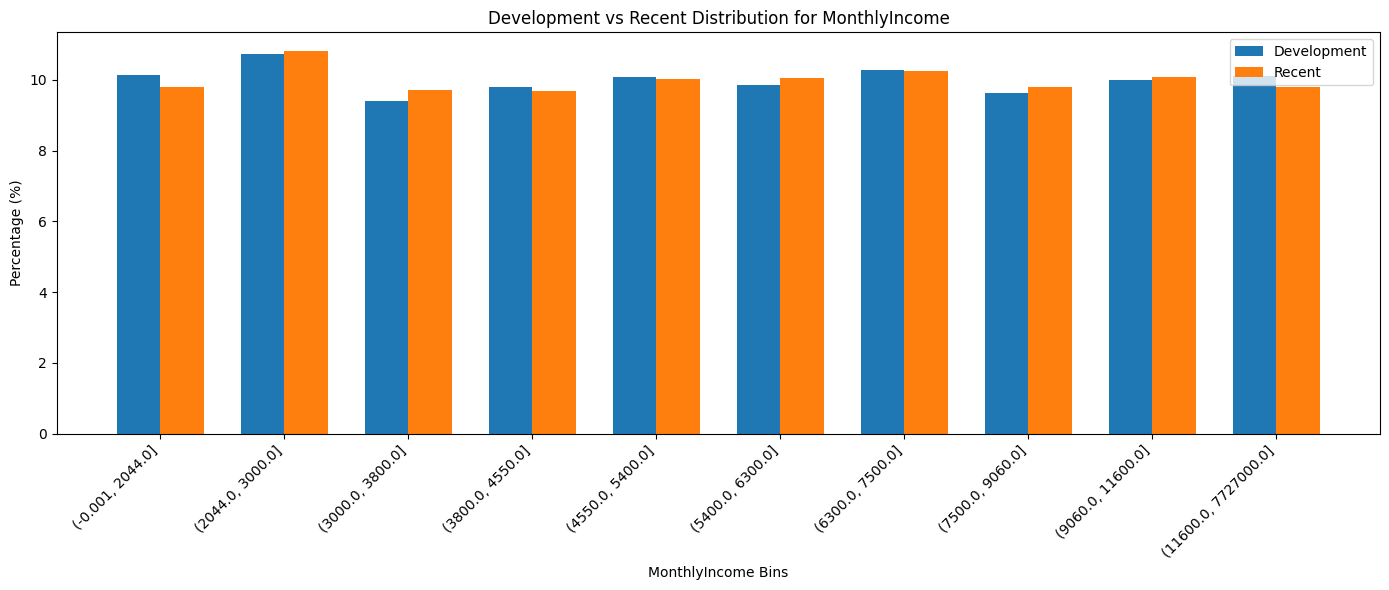


 Full CSI Table for Feature: NumberOfOpenCreditLinesAndLoans


<ipython-input-11-7d35ae5cd8aa>:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([csi_report, total_row], ignore_index=True)


,NumberOfOpenCreditLinesAndLoans Bins,Development Apps #,Current Apps #,Development %,Current %,Change (decimal),Ratio (Current % / Development %),WOE ln(Ratio),Contribution to Index,Score for Attribute,Score Difference
0,"(-0.001, 3.0]",22050,14922,14.70,14.70,0.000000e+00,1.00,0.00,0.000000,25.24,0.030000
1,"(3.0, 4.0]",11609,7779,7.74,7.66,-8.000000e-02,0.99,-0.01,0.000000,17.46,-1.320000
2,"(4.0, 5.0]",12931,8727,8.62,8.60,-2.000000e-02,1.00,-0.00,0.000000,23.09,-0.530000
3,"(5.0, 6.0]",13614,9217,9.08,9.08,0.000000e+00,1.00,0.00,0.000000,25.58,0.120000
4,"(6.0, 8.0]",25807,17577,17.20,17.32,1.100000e-01,1.01,0.01,0.000000,30.29,3.390000
5,"(8.0, 9.0]",11355,7537,7.57,7.43,-1.400000e-01,0.98,-0.02,0.000000,10.00,-1.450000
6,"(9.0, 10.0]",9624,6721,6.42,6.62,2.100000e-01,1.03,0.03,0.010000,50.00,10.270000
7,"(10.0, 12.0]",15326,10375,10.22,10.22,0.000000e+00,1.00,0.00,0.000000,25.49,0.100000
8,"(12.0, 15.0]",13858,9353,9.24,9.21,-2.000000e-02,1.00,-0.00,0.000000,23.12,-0.560000
9,"(15.0, 85.0]",13826,9295,9.22,9.16,-6.000000e-02,0.99,-0.01,0.000000,20.04,-1.200000


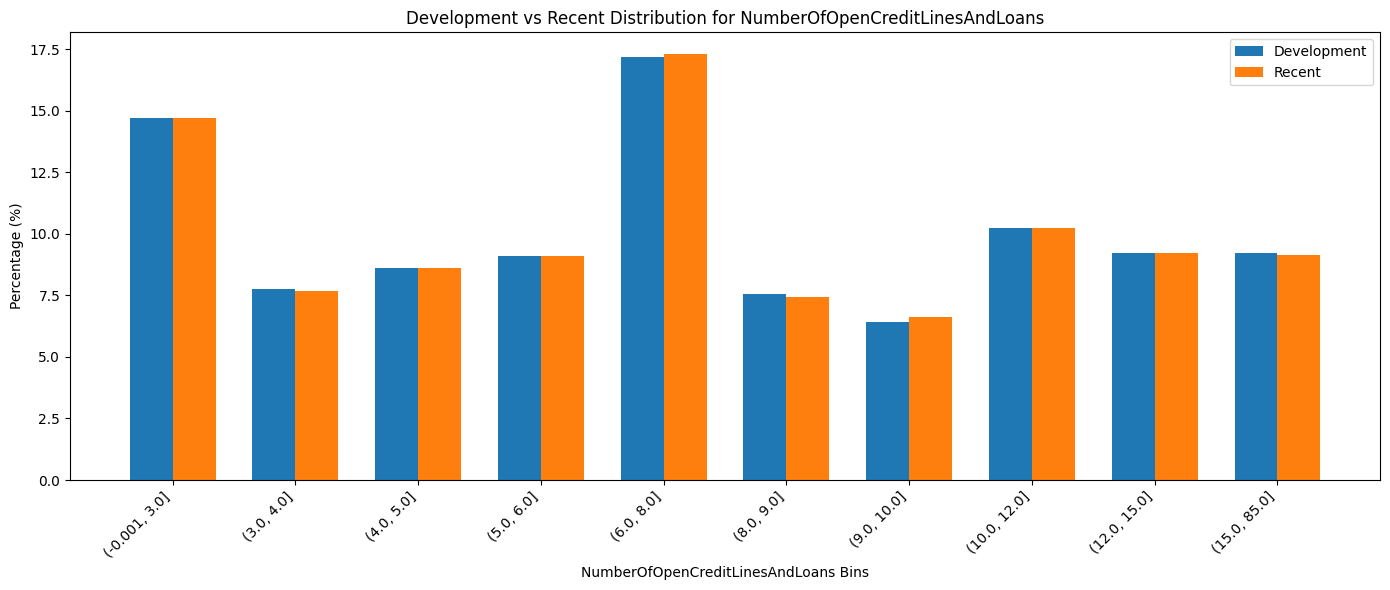


 Full CSI Table for Feature: NumberOfTimes90DaysLate


<ipython-input-11-7d35ae5cd8aa>:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([csi_report, total_row], ignore_index=True)


,NumberOfTimes90DaysLate Bins,Development Apps #,Current Apps #,Development %,Current %,Change (decimal),Ratio (Current % / Development %),WOE ln(Ratio),Contribution to Index,Score for Attribute,Score Difference
0,"(-0.001, 98.0]",150000,101503,100.0,100.0,0.0,1.0,0.0,0.0,10,0.0
1,Total,150000,101503,100.0,100.0,0.0,NaN,NaN,0.0,None,0.0


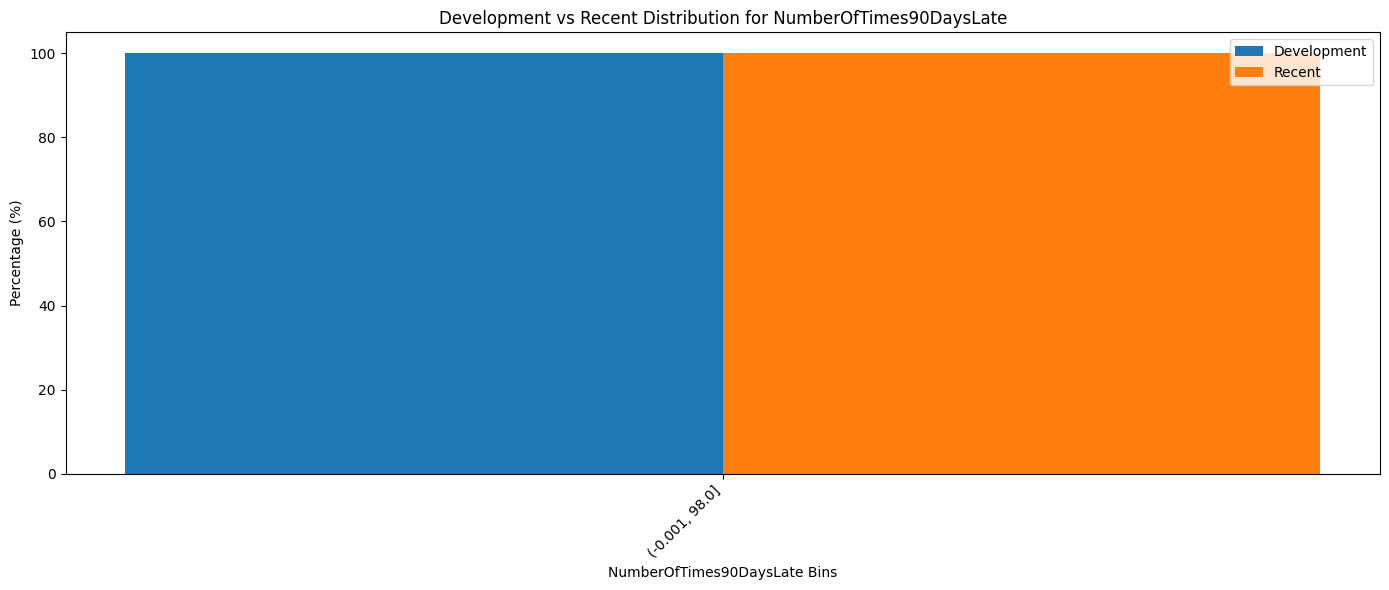


 Full CSI Table for Feature: NumberRealEstateLoansOrLines


<ipython-input-11-7d35ae5cd8aa>:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([csi_report, total_row], ignore_index=True)


,NumberRealEstateLoansOrLines Bins,Development Apps #,Current Apps #,Development %,Current %,Change (decimal),Ratio (Current % / Development %),WOE ln(Ratio),Contribution to Index,Score for Attribute,Score Difference
0,"(-0.001, 1.0]",108526,73736,72.35,72.64,2.900000e-01,1.00,0.00,0.000000,39.86,11.700000
1,"(1.0, 2.0]",31522,20955,21.01,20.64,-3.700000e-01,0.98,-0.02,0.010000,10.00,-3.700000
2,"(2.0, 54.0]",9952,6812,6.63,6.71,8.000000e-02,1.01,0.01,0.000000,50.00,3.820000
3,Total,150000,101503,100.00,100.00,-3.552714e-15,NaN,NaN,0.008635,NaN,11.820888


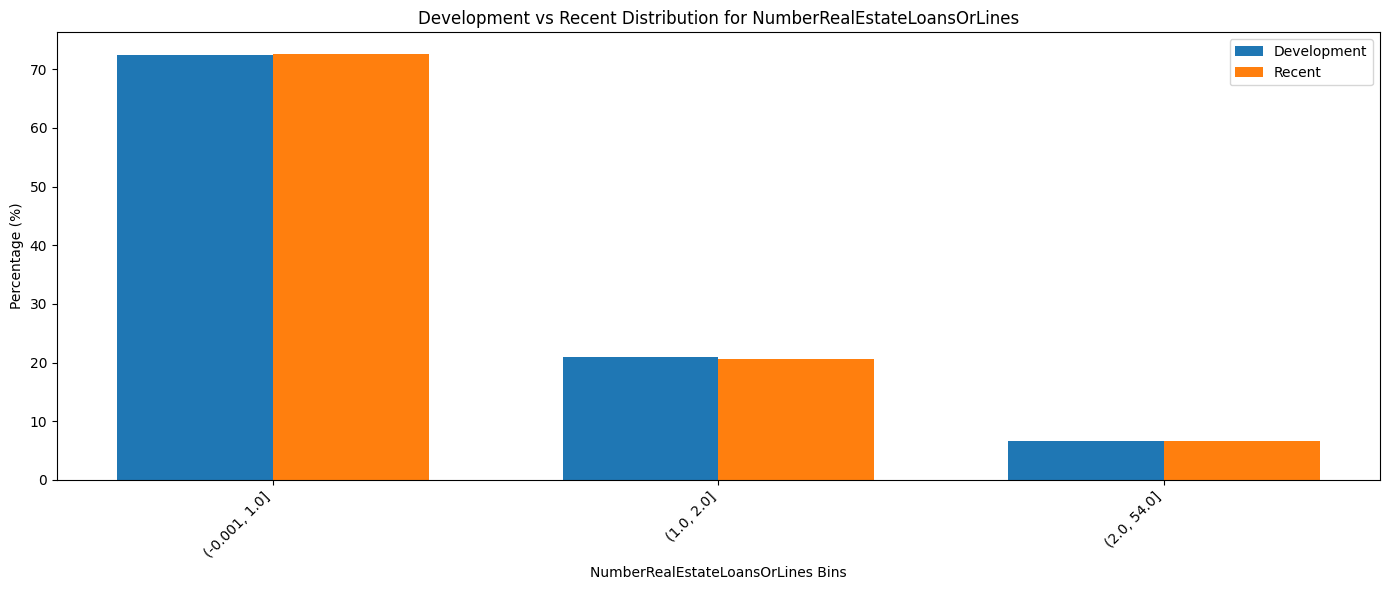


 Full CSI Table for Feature: NumberOfTime60-89DaysPastDueNotWorse


<ipython-input-11-7d35ae5cd8aa>:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([csi_report, total_row], ignore_index=True)


,NumberOfTime60-89DaysPastDueNotWorse Bins,Development Apps #,Current Apps #,Development %,Current %,Change (decimal),Ratio (Current % / Development %),WOE ln(Ratio),Contribution to Index,Score for Attribute,Score Difference
0,"(-0.001, 98.0]",150000,101503,100.0,100.0,0.0,1.0,0.0,0.0,10,0.0
1,Total,150000,101503,100.0,100.0,0.0,NaN,NaN,0.0,None,0.0


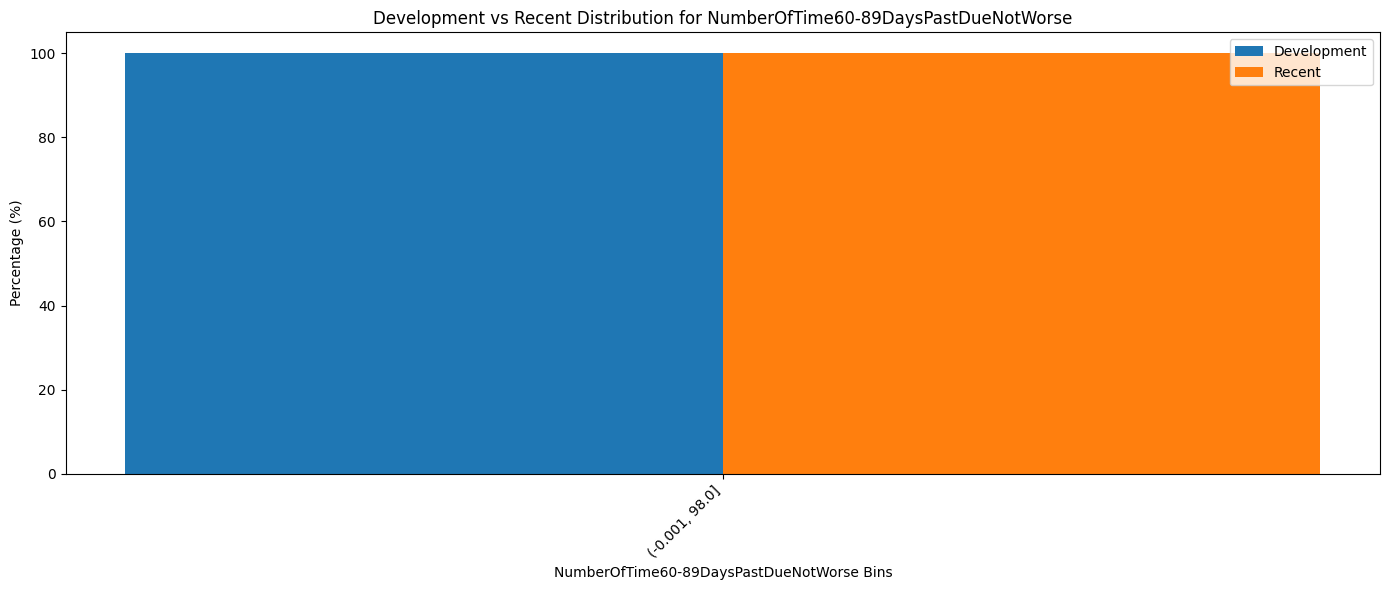


 Full CSI Table for Feature: NumberOfDependents


<ipython-input-11-7d35ae5cd8aa>:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([csi_report, total_row], ignore_index=True)


,NumberOfDependents Bins,Development Apps #,Current Apps #,Development %,Current %,Change (decimal),Ratio (Current % / Development %),WOE ln(Ratio),Contribution to Index,Score for Attribute,Score Difference
0,"(-0.001, 1.0]",113218,76236,77.51,77.10,-4.000000e-01,0.99,-0.01,0.000000,10.00,-4.040000
1,"(1.0, 2.0]",19522,13298,13.36,13.45,8.000000e-02,1.01,0.01,0.000000,21.66,1.840000
2,"(2.0, 43.0]",13336,9343,9.13,9.45,3.200000e-01,1.04,0.03,0.010000,50.00,15.980000
3,Total,146076,98877,100.00,100.00,1.243450e-14,NaN,NaN,0.013649,NaN,13.772815


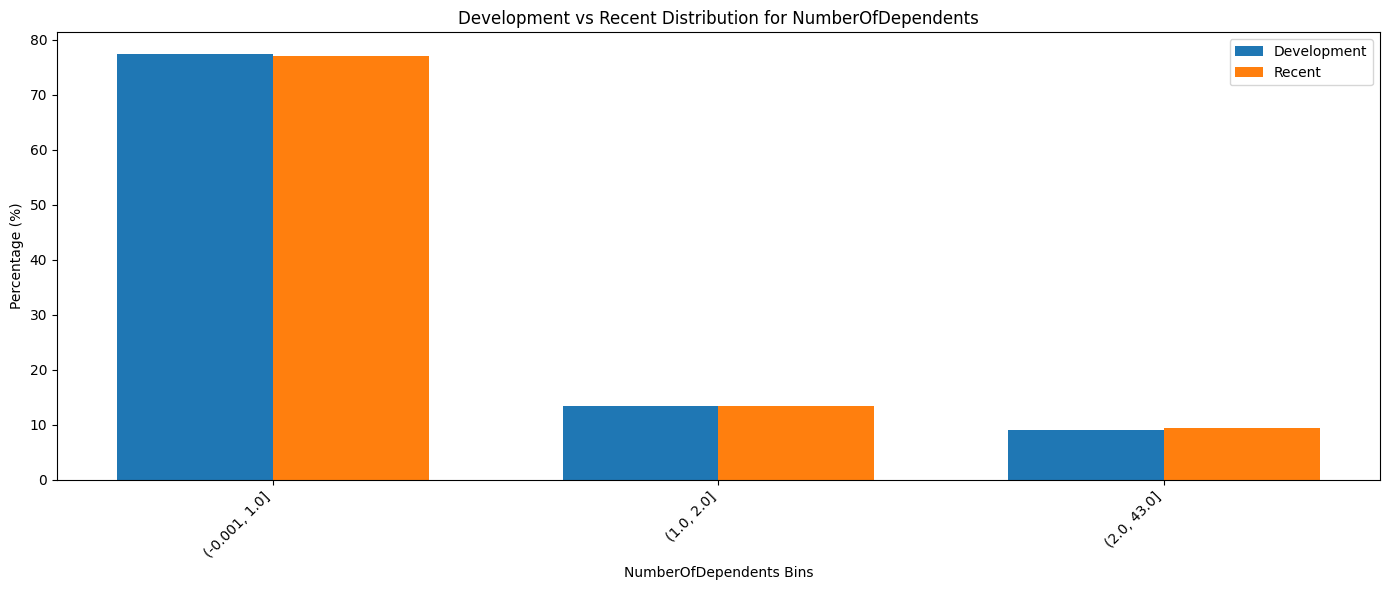


 Full CSI Table for Feature: Score_Band
[ERROR] Failed to compute CSI for Score_Band: 


In [12]:
bin_config = {}
dev_data['Dataset'] = 'Development'
rec_data['Dataset'] = 'Recent'
df_all = pd.concat([dev_data, rec_data], ignore_index=True)

exclude_cols = ['SeriousDlqin2yrs', 'Default_Probability', 'Internal_Credit_Score', 'Dataset']
model_features = [col for col in dev_data.columns if col not in exclude_cols]

full_csi_reports = {}

for feature in model_features:
    print(f"\n Full CSI Table for Feature: {feature}")
    try:
        csi_df = compute_csi(df_all, feature, bin_config)
        full_csi_reports[feature] = csi_df

        display(csi_df)

        csi_plot_df = csi_df[csi_df[f'{feature} Bins'] != 'Total']
        x = np.arange(len(csi_plot_df))
        width = 0.35

        fig, ax = plt.subplots(figsize=(14, 6))
        ax.bar(x - width/2, csi_plot_df['Development %'], width, label='Development')
        ax.bar(x + width/2, csi_plot_df['Current %'], width, label='Recent')

        ax.set_xlabel(f"{feature} Bins")
        ax.set_ylabel("Percentage (%)")
        ax.set_title(f"Development vs Recent Distribution for {feature}")
        ax.set_xticks(x)
        ax.set_xticklabels(csi_plot_df[f'{feature} Bins'], rotation=45, ha='right')
        ax.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"[ERROR] Failed to compute CSI for {feature}: {e}")


### Interpreting CSI Score Difference

### Interpreting CSI Score Difference

To evaluate the distributional stability of input features, we use the *Score Difference* from the CSI report.

**Interpretation guideline for this model:**

- *Score Difference ≤ 12*: Acceptable variation — feature is considered stable.
- *Score Difference > 12*: Significant distributional shift — feature should be reviewed for data drift, operational changes, or pipeline issues.

> *Note:* The threshold of 12 is **arbitrary** and can vary depending on the organization's model risk policy, program management standards, or monitoring framework. It has been selected here based on the observed behavior of the features and for demonstration purposes.

In [13]:
print("\n Final Score Difference Summary by Feature:\n")

for feature, csi_df in full_csi_reports.items():
    try:
        total_score_diff = csi_df.loc[csi_df[f'{feature} Bins'] == 'Total', 'Score Difference'].values[0]
        print(f"* {feature}: {total_score_diff:.2f}")
    except Exception as e:
        print(f"Could not extract score difference for {feature}: {e}")



 Final Score Difference Summary by Feature:

* Unnamed: 0: 690.65
* RevolvingUtilizationOfUnsecuredLines: 14.63
* age: 10.95
* NumberOfTime30-59DaysPastDueNotWorse: 3.82
* DebtRatio: 12.57
* MonthlyIncome: 24.52
* NumberOfOpenCreditLinesAndLoans: 8.86
* NumberOfTimes90DaysLate: 0.00
* NumberRealEstateLoansOrLines: 11.82
* NumberOfTime60-89DaysPastDueNotWorse: 0.00
* NumberOfDependents: 13.77


### Recommendations


- Several features **exceeded the 12-point threshold**, indicating a *material change in distribution* that may affect model reliability. These variables should be:
  - Reviewed for potential data drift or external shifts in customer behavior
  - Investigated for operational or policy-related changes
  - Prioritized in ongoing monitoring or challenger model development

- Features that remained **below the threshold** are considered **stable** for now. However, continued periodic monitoring is essential, as shifts may accumulate gradually over time.

### Action Points

- **Flag and escalate** shifted features to model risk or validation teams if this were a production system.
- **Log findings** in a monitoring report to track trend consistency over time.
- Consider **refitting or recalibrating the model** if drifted features have high importance or show correlation with performance degradation.
- Integrate CSI tracking into a **monthly monitoring dashboard** to automate future alerts.

### KDE Plot of Internal Credit Score Distribution

This KDE plot compares the distribution of the **internal credit score** between the development and recent populations.

- **Blue (df_dev)** represents the development dataset.
- **Orange (df_rec)** represents the recent dataset.

The goal is to visually inspect any shifts in the score distribution over time — complementing the quantitative analysis from the PSI.


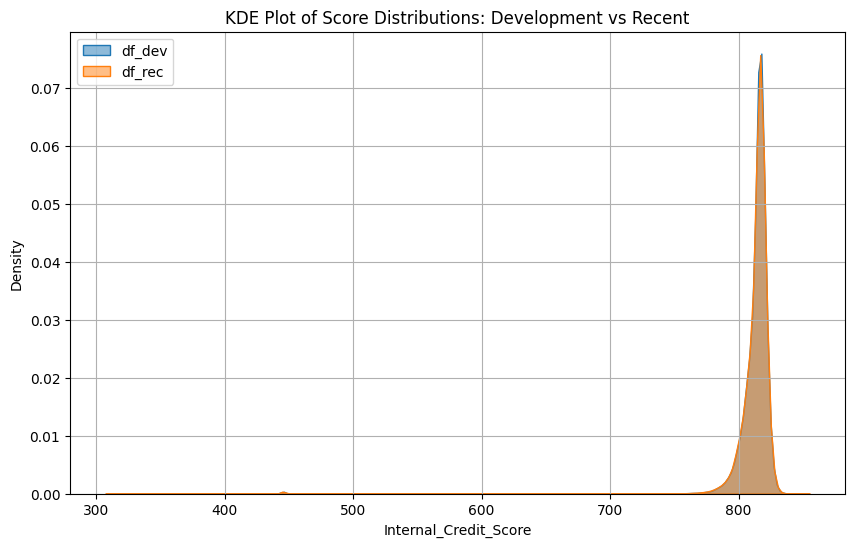

In [14]:
import seaborn as sns

df_rec_graph = rec_data.copy()
df_rec_graph['Internal_Credit_Score'] = df_rec_graph['Internal_Credit_Score']

df_dev_graph = dev_data.copy()
df_dev_graph['Internal_Credit_Score'] = df_dev_graph['Internal_Credit_Score']
plt.figure(figsize=(10, 6))
sns.kdeplot(df_dev_graph['Internal_Credit_Score'], fill=True, label='df_dev', alpha=0.5)
sns.kdeplot(df_rec_graph['Internal_Credit_Score'], fill=True, label='df_rec', alpha=0.5)
plt.title('KDE Plot of Score Distributions: Development vs Recent')
plt.xlabel('Internal_Credit_Score')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


#### Interpretation

- The **shapes of the two distributions are very similar**, with nearly identical peaks and spread.
- This aligns with the **low PSI value (~0.028)** calculated earlier, suggesting *no significant score drift*.
- No secondary peaks or skewing in the recent data are present, which could have indicated a major change in applicant behavior or creditworthiness.


#### Conclusion

The KDE plot supports the conclusion that the **scorecard remains stable** across time periods. When combined with PSI and CSI analysis, this provides strong evidence that the model is operating within expected boundaries — a key component of any model monitoring framework.

### KDE Plot of Monthly Income Distribution

This KDE plot compares the distribution of the *MonthlyIncome* feature between the **development** and **recent** populations.

- **Blue (df_dev)**: Applicants from the development dataset  
- **Orange (df_rec)**: Applicants from the recent dataset  


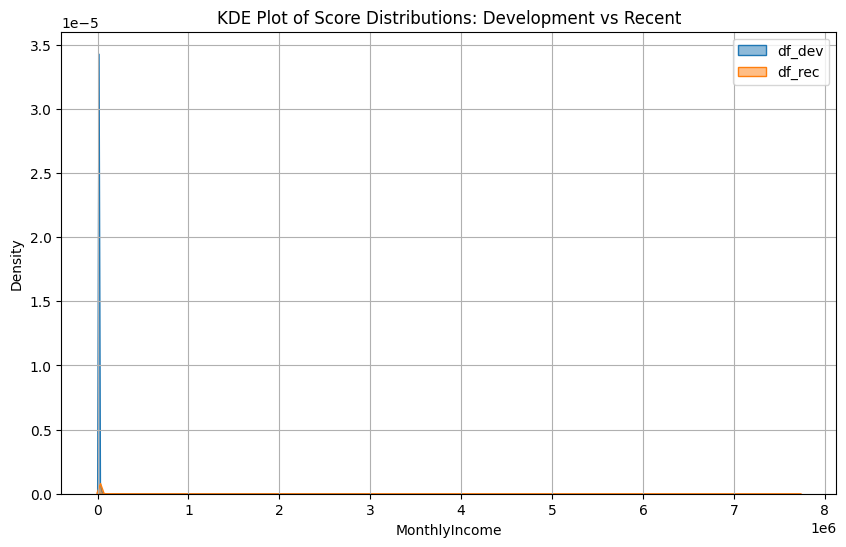

In [15]:
import seaborn as sns

df_rec_graph = rec_data.copy()
df_rec_graph['MonthlyIncome'] = df_rec_graph['MonthlyIncome']

df_dev_graph = dev_data.copy()
df_dev_graph['MonthlyIncome'] = df_dev_graph['MonthlyIncome']
plt.figure(figsize=(10, 6))
sns.kdeplot(df_dev_graph['MonthlyIncome'], fill=True, label='df_dev', alpha=0.5)
sns.kdeplot(df_rec_graph['MonthlyIncome'], fill=True, label='df_rec', alpha=0.5)
plt.title('KDE Plot of Score Distributions: Development vs Recent')
plt.xlabel('MonthlyIncome')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()




#### Interpretation

- The KDE curves show a **visible shift in the MonthlyIncome distribution** over time.
- The recent population appears to be more concentrated in the **lower income ranges**, with a **thinner right tail**, suggesting a possible reduction in higher-income applicants.
- This aligns with the earlier CSI analysis, where *MonthlyIncome* showed a **Score Difference > 20**, indicating a material change in this characteristic’s distribution.

#### Implication

- A shift in MonthlyIncome can have a **direct impact on risk profile and model behavior**, especially if income is a key predictive feature.
- This supports the case for **further investigation**, including:
  - Changes in income reporting or imputation
  - Shifts in applicant demographics
  - Possible external factors (e.g., economic conditions)


#### Recommendation

- Flag this feature for deeper review in the context of model inputs.
- Consider ongoing monitoring of income distribution as part of a monthly stability dashboard.
- If the model relies heavily on this feature, a **performance impact assessment** or **model recalibration** may be warranted.